In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

import env

Initial Questions:

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?


In [2]:
def get_curriculum_logs():
    filename = "curriculum-logs.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=False)
    else
        # read the SQL query into a dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        query = '''
        SELECT *
        FROM logs
        LEFT JOIN cohorts ON logs.cohort_id = cohorts.id;
        '''
        df = pd.read_sql(query, url)

        # Write that dataframe to disk for later.
        df.to_csv(filename, index = False)

        return df

In [3]:
# acquire data using the above function
df = get_curriculum_logs()
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [4]:
# convert date to a pandas datetime format and set as index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [5]:
# drop original date column
df.drop(columns='date',inplace=True)

In [6]:
df.head()

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [7]:
# rename the following columns for clarity
df.rename(columns = {'path':'endpoint', 'ip':'ip_address', 'name':'cohort_name'}, inplace = True)

In [8]:
df.head()

,time,endpoint,user_id,cohort_id,ip_address,id,cohort_name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [9]:
# drop the following columns
df.drop(columns=['time', 'id', 'slack', 'deleted_at'], inplace=True)
df.head()

,endpoint,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,created_at,updated_at,program_id
date,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0


In [10]:
df['program_name'] = df.program_id.map({1.0: 'PHP Full Stack Web Development',
                                        2.0: 'Java Full Stack Web Development',
                                        3.0: 'Data Science',
                                        4.0: 'Front End Web Development'})

In [11]:
df['program'] = df.program_id.map({1.0: 'Web Development',
                                   2.0: 'Web Development',
                                   3.0: 'Data Science',
                                   4.0: 'Web Development'})

In [12]:
df.head()

,endpoint,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,created_at,updated_at,program_id,program_name,program
date,,,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,PHP Full Stack Web Development,Web Development
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,PHP Full Stack Web Development,Web Development
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,PHP Full Stack Web Development,Web Development
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,PHP Full Stack Web Development,Web Development
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Java Full Stack Web Development,Web Development


In [13]:
df.drop(columns='program_name',inplace=True)
df.drop(columns='program_id',inplace=True)
df.head()

,endpoint,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,created_at,updated_at,program_id,program
date,,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Web Development


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   endpoint     900222 non-null  object 
 1   user_id      900223 non-null  int64  
 2   cohort_id    847330 non-null  float64
 3   ip_address   900223 non-null  object 
 4   cohort_name  847330 non-null  object 
 5   start_date   847330 non-null  object 
 6   end_date     847330 non-null  object 
 7   created_at   847330 non-null  object 
 8   updated_at   847330 non-null  object 
 9   program_id   847330 non-null  float64
 10  program      847330 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 82.4+ MB


# Exploration

### Question 1: Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [28]:
DS_df = df[(df.program == 'Data Science')]
DS_df.head(5)

,endpoint,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,created_at,updated_at,program_id,program
date,,,,,,,,,,,
2019-08-20,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science
2019-08-20,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science
2019-08-20,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science
2019-08-20,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science
2019-08-20,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science


In [29]:
Wb_df = df[(df.program == 'Web Development')]
Wb_df.head(5)

,endpoint,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,created_at,updated_at,program_id,program
date,,,,,,,,,,,
2018-01-26,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Development
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Web Development


In [25]:
page_views = df.groupby(['user_id'])['endpoint'].agg(['count', 'unique'])
page_views

,count,unique
user_id,,
1,7404,"[/, java-ii, java-ii/object-oriented-programmi..."
2,1541,"[javascript-i/conditionals, javascript-i/loops..."
3,1562,"[javascript-i/conditionals, javascript-i/funct..."
4,692,"[javascript-i/functions, javascript-i/introduc..."
5,1701,"[mkdocs/search_index.json, appendix/further-re..."
...,...,...
977,86,"[/, javascript-i, javascript-i/javascript-with..."
978,55,"[/, toc, javascript-i, javascript-i/introducti..."
979,127,"[/, toc, javascript-i/introduction, javascript..."


In [26]:
page_views.shape

(981, 2)

In [16]:
cohort_requests = df.groupby('cohort_id').resample('W').size().unstack(0)
cohort_requests.head()

cohort_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,12.0,...,59.0,61.0,62.0,132.0,133.0,134.0,135.0,137.0,138.0,139.0
date,,,,,,,,,,,,,,,,,,,,,
2018-01-28,19.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,74.0,NaN,4.0,NaN,NaN,10.0,36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-11,78.0,NaN,NaN,NaN,NaN,0.0,36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-18,86.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-25,90.0,NaN,NaN,NaN,NaN,0.0,85.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

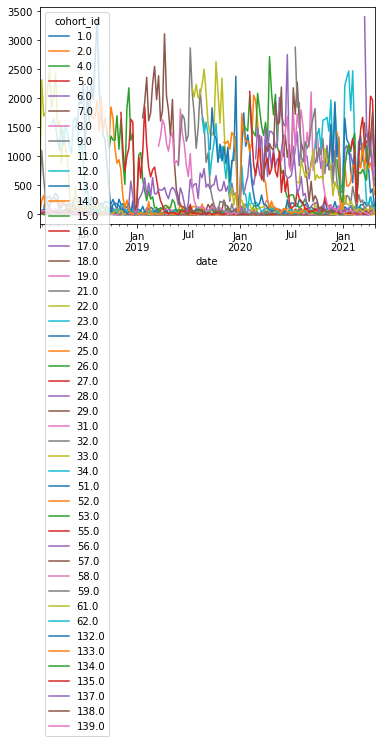

In [17]:
cohort_requests.plot()

In [21]:
df.groupby(['cohort_name','program']).sum().user_id.nlargest(10)

cohort_name  program        
Jupiter      Web Development    28296551
Darden       Data Science       21820199
Staff        Web Development    21734659
Ganymede     Web Development    21514819
Apex         Web Development    20433773
Hyperion     Web Development    19866593
Fortuna      Web Development    19853599
Kalypso      Web Development    18657118
Ceres        Web Development    18196972
Deimos       Web Development    16435533
Name: user_id, dtype: int64

### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

### 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?